# TxMM Project 2023
Freek Hens \\
s1033509



---

# <center>How often do you think about the Roman Empire?</center>
<center>A study comparing X thoughts of Dutch people about the Roman Empire


# Get the data

In [30]:
!pip install -q transformers datasets

In [31]:
import transformers
import datasets
import pandas as pd
import regex as re
import numpy as np
from sklearn.model_selection import train_test_split
import torch

tweets = pd.read_csv("drive/MyDrive/tweets.csv", index_col="Unnamed: 0")
print(len(tweets))
tweets.head(2)

1850225


,id,text,username
0,1080222141394620416,Napoli denkt aan Anderlecht-flop als concurren...,voetbalnieuwsbe
1,1080222141663068160,USERNAME Wow! Ben ik hier de oudste?🙈,Papa_Mischa


In [32]:
def preprocess(dataf):
    df = dataf.copy()
    def isRetweet(string):
        return bool(re.search('RT @', string))

    df['is_retweet'] = df.text.map(isRetweet)
    print("# Retweets found:", sum(df['is_retweet']))
    print("# Duplicates found:", sum(df.duplicated('text')))
    df['is_duplicate'] = df.duplicated('text', keep='first')

    counts = df.username.value_counts()
    threshold = 2
    # Create a list of usernames of all people who exceed the threshold
    spammers = (counts > threshold)
    spammers = spammers[spammers == True].index
    df['is_from_spammer'] = df.id.isin(spammers)
    print("# Spammers found:", sum(df['is_from_spammer']))
    df['to_keep'] = ~ (df.is_duplicate | df.is_from_spammer)
    df = df[df.to_keep]

    # uses a regex to detect usernames and replaces them by USERNAME
    def replace_username(in_string):
        return re.sub('@(\w){1,15}','USERNAME',in_string)
    # uses a regex to detect hashtags and replaces them by HASHTAG
    def replace_hashtag(in_string):
        return re.sub('#(\w)*','HASHTAG',in_string)
    # uses a regex to detect links and replaces them by LINK
    def replace_link(in_string):
        return re.sub('(http:)?//t.co/\w*', 'LINK',in_string)

    # map the text to itself, applying each of the functions
    df.text = df.text.map(replace_username)
    df.text = df.text.map(replace_hashtag)
    df.text = df.text.map(replace_link)

    # Remove the rubbish columns now
    df.drop(["is_retweet", "is_duplicate", "to_keep", "is_from_spammer"], axis=1, inplace=True)
    return df

processed = preprocess(tweets)
processed


# Retweets found: 1
# Duplicates found: 147574
# Spammers found: 0


,id,text,username
0,1080222141394620416,Napoli denkt aan Anderlecht-flop als concurren...,voetbalnieuwsbe
1,1080222141663068160,USERNAME Wow! Ben ik hier de oudste?🙈,Papa_Mischa
2,1080222141801476098,Temperatuur=6.2|Regen.dag=1.0mm|Wind=3.0&lt;br...,Weer_Rotterdam
3,1080222141973491713,USERNAME zag je net bij Smaakt naar meer en tw...,weetje11
4,1080222142040559617,USERNAME USERNAME Mooi! Houden zo.,petatteke
...,...,...,...
2725432,1080977125530914816,RT USERNAME: DIFFONDIAMO QUESTO VIDEO - E' IMP...,conlanima
2725433,1080977127242153984,HASHTAG - HASHTAG Ynılgılrımızın cogudüşüneceg...,BurcuClz2
2725437,1080977136855461889,"mano, fuscao anda muito mais que uns carrinho ...",m4zzotti
2725438,1080977143453138945,"00:56 Temp. 1.9°C, Hum. 87%, Dewp. -0.7°C, Bar...",PVEDM


In [33]:
tweets = processed.copy()
roman_empire_keywords = ["romein", "caesar", "aurelius"]

def contains_roman_empire_keywords(tweet):
    for keyword in roman_empire_keywords:
        if keyword.lower() in str(tweet).lower():
            return 1
    return 0

tweets['is_about_roman_empire'] = tweets['text'].apply(contains_roman_empire_keywords)
print(f'Found {sum(tweets["is_about_roman_empire"])} roman tweets')
n_roman_tweets = sum(tweets["is_about_roman_empire"])

tweets.head(2)

Found 209 roman tweets


,id,text,username,is_about_roman_empire
0,1080222141394620416,Napoli denkt aan Anderlecht-flop als concurren...,voetbalnieuwsbe,0
1,1080222141663068160,USERNAME Wow! Ben ik hier de oudste?🙈,Papa_Mischa,0


In [34]:
labelled_set = pd.concat([tweets[tweets.is_about_roman_empire == 1], tweets[tweets.is_about_roman_empire == 0].sample(n_roman_tweets)])
labelled_set

labelled_idx = labelled_set.index
not_labelled_idx = tweets.index.difference(labelled_idx)
print(len(labelled_idx), "labelled data")

tweets.loc[labelled_idx, "labelled"] = 1
tweets.loc[not_labelled_idx, "labelled"] = 0

tweets

418 labelled data


,id,text,username,is_about_roman_empire,labelled
0,1080222141394620416,Napoli denkt aan Anderlecht-flop als concurren...,voetbalnieuwsbe,0,0.0
1,1080222141663068160,USERNAME Wow! Ben ik hier de oudste?🙈,Papa_Mischa,0,0.0
2,1080222141801476098,Temperatuur=6.2|Regen.dag=1.0mm|Wind=3.0&lt;br...,Weer_Rotterdam,0,0.0
3,1080222141973491713,USERNAME zag je net bij Smaakt naar meer en tw...,weetje11,0,0.0
4,1080222142040559617,USERNAME USERNAME Mooi! Houden zo.,petatteke,0,0.0
...,...,...,...,...,...
2725432,1080977125530914816,RT USERNAME: DIFFONDIAMO QUESTO VIDEO - E' IMP...,conlanima,0,0.0
2725433,1080977127242153984,HASHTAG - HASHTAG Ynılgılrımızın cogudüşüneceg...,BurcuClz2,0,0.0
2725437,1080977136855461889,"mano, fuscao anda muito mais que uns carrinho ...",m4zzotti,0,0.0
2725438,1080977143453138945,"00:56 Temp. 1.9°C, Hum. 87%, Dewp. -0.7°C, Bar...",PVEDM,0,0.0


In [35]:
# train test split
X_tr, X_ts, y_tr, y_ts = train_test_split(labelled_set.text, labelled_set.is_about_roman_empire, test_size=0.2, random_state=42)
# train val split
X_tr, X_val, y_tr, y_val = train_test_split(X_tr, y_tr, test_size=0.2, random_state=42)

print(len(X_tr), "train set")
print(len(X_val), "val set")
print(len(X_ts), "test set")

267 train set
67 val set
84 test set


# Train classifier

In [51]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from torch.optim import AdamW

model_checkpoint = "bert-base-uncased"
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint)
tok = AutoTokenizer.from_pretrained(model_checkpoint)

optimizer = AdamW(model.parameters(), lr=2e-5)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [37]:
def tokenize_function(example):
    return tok(
        example,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )

X_tr_tok = list(X_tr.map(tokenize_function))
X_val_tok = list(X_val.map(tokenize_function))
X_ts_tok = list(X_ts.map(tokenize_function))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [38]:
import torch
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, X, y):
        if len(X) != len(y):
            raise ValueError("Lengths of X and y must be the same.")

        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if idx >= len(self.X):
            raise IndexError(f"Index {idx} is out of range. Dataset length: {len(self.X)}")

        sample = self.X[idx]

        input_ids = sample['input_ids'].long()
        # token_type_ids = sample['token_type_ids'].long()
        attention_mask = sample['attention_mask'].long()
        label = torch.tensor(self.y[idx], dtype=torch.long)

        return {
            'input_ids': input_ids,
            # 'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'attention_mask': attention_mask,
            'label': label
        }

train_dataset = CustomDataset(X_tr_tok, list(y_tr))
val_dataset = CustomDataset(X_val_tok, list(y_val))
test_dataset = CustomDataset(X_ts_tok, list(y_ts))


In [52]:
from sklearn.metrics import accuracy_score

# Assuming train_dataset and val_dataset are already defined
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

print(len(train_loader))
print(len(val_loader))

# Training loop
num_epochs = 4
print(device)
model.to(device)

train_losses = []
val_losses = []
accs = []

for epoch in range(num_epochs):
    model.train()

    train_loss_epoch = []
    val_loss_epoch = []

    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        if labels.size()[0] > 1:
            input_ids, attention_mask, labels = (t.squeeze() for t in (input_ids, attention_mask, labels))
        else:
            input_ids = input_ids.squeeze(1)
            attention_mask = attention_mask.squeeze(1)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        train_loss_epoch.append(loss.item())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    avg_tr_loss_epoch = sum(train_loss_epoch)/len(train_loss_epoch)
    train_losses.append(avg_tr_loss_epoch)

    # Validation loop
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            if labels.size()[0] > 1:
                input_ids, attention_mask, labels = (t.squeeze() for t in (input_ids, attention_mask, labels))
            else:
                input_ids = input_ids.squeeze(1)
                attention_mask = attention_mask.squeeze(1)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            val_loss_epoch.append(loss.item())

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_val_loss_epoch = sum(val_loss_epoch)/len(val_loss_epoch)
    val_losses.append(avg_val_loss_epoch)

    val_accuracy = accuracy_score(all_labels, all_preds)
    accs.append(val_accuracy)
    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_tr_loss_epoch:.4f}, Val Loss: {avg_val_loss_epoch:.4f} \n Validation Accuracy: {val_accuracy:.4f}')

67
17
cuda
Epoch 1/4, Train Loss: 0.6007, Val Loss: 0.2614 
 Validation Accuracy: 0.9254
Epoch 2/4, Train Loss: 0.0996, Val Loss: 0.0139 
 Validation Accuracy: 1.0000
Epoch 3/4, Train Loss: 0.0203, Val Loss: 0.0070 
 Validation Accuracy: 1.0000
Epoch 4/4, Train Loss: 0.0054, Val Loss: 0.0033 
 Validation Accuracy: 1.0000


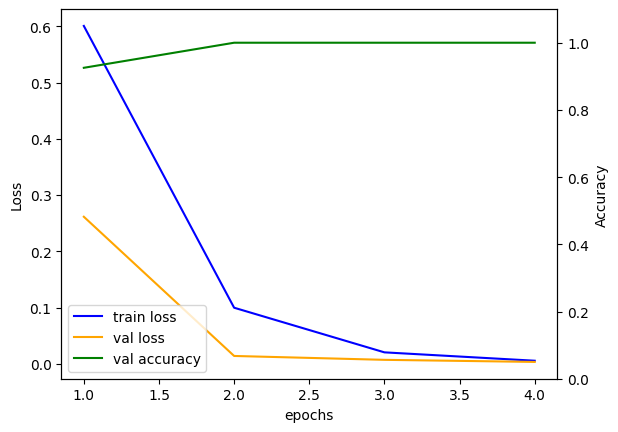

In [53]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)
fig, ax1 = plt.subplots()
line1 = ax1.plot(epochs, train_losses, label="train loss", color='blue')
line2 = ax1.plot(epochs, val_losses, label="val loss", color='orange')
ax1.set_xlabel("epochs")
ax1.set_ylabel("Loss", color='black')
ax1.tick_params('y', colors='black')
ax2 = ax1.twinx()
line3 = ax2.plot(epochs, accs, label="val accuracy", color='green')
ax2.set_ylabel("Accuracy", color='black')
ax2.tick_params('y', colors='black')
ax2.set_ylim(0,1.1)
lines = line1 + line2 + line3
labels = [l.get_label() for l in lines]
plt.legend(lines, labels)

plt.show()

# Test

In [54]:
# Test loop
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)
print(len(test_loader))

model.eval()
all_test_preds = []
all_test_labels = []
logits_ls = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        if labels.size()[0] > 1:
            input_ids, attention_mask, labels = (t.squeeze() for t in (input_ids, attention_mask, labels))
        else:
            input_ids = input_ids.squeeze(1)
            attention_mask = attention_mask.squeeze(1)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        logits_ls.extend(torch.nn.functional.softmax(logits, dim=-1)[:, 1].cpu().numpy())

        all_test_preds.extend(preds.cpu().numpy())
        all_test_labels.extend(labels.cpu().numpy())

# Calculate accuracy on the test set
test_accuracy = accuracy_score(all_test_labels, all_test_preds)
print(f'Test Accuracy: {test_accuracy:.4f}')

11
Test Accuracy: 1.0000


[0.00278678 0.00330192 0.00267504 0.99590486 0.99708694 0.9979341
 0.99727374 0.9980725  0.00275858 0.00301185 0.99808204 0.01329604
 0.99809617 0.00244114 0.00256332 0.9980818  0.00266619 0.00377101
 0.9980574  0.00646207 0.00247693 0.00285357 0.0023783  0.99803036
 0.00261259 0.9980361  0.00368153 0.99804246 0.005727   0.9980525
 0.00268015 0.00300196 0.9980888  0.9980913  0.00399311 0.9967524
 0.9980824  0.00272009 0.00645535 0.99809617 0.9980136  0.9980477
 0.9980907  0.01159648 0.9980617  0.00260828 0.0040164  0.998064
 0.9971105  0.00360517 0.99795496 0.99795663 0.00393781 0.00256615
 0.00258969 0.00305331 0.99706215 0.9980652  0.00257816 0.00295991
 0.99801993 0.00274406 0.99799204 0.0053547  0.9970511  0.00247071
 0.99798167 0.9979583  0.00265806 0.00343864 0.00305608 0.00391249
 0.02273867 0.997993   0.997898   0.00311905 0.002742   0.997707
 0.99800664 0.9970921  0.9971021  0.99717975 0.99694103 0.99723744]
84


[]

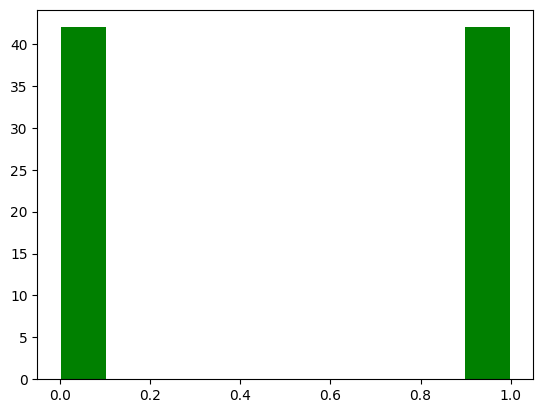

In [55]:
correct = np.array(all_test_labels) == np.array(all_test_preds)
false = np.array(all_test_labels) != np.array(all_test_preds)

logits_ls = np.array(logits_ls)
print(logits_ls)
print(len(logits_ls))

plt.hist(logits_ls[correct], bins=10, color='green')
plt.hist(logits_ls[false], bins=10, color='red')
plt.plot()

### Manual input test

In [56]:
manual_test = pd.Series(["Die romeinen waren zo cool eigenlijk vroeger.",
                         "Rare jongens, die Italianen met hun aquaducten enzo vroeger.",
                         "Mama heeft lekker gekookt vandaag.",
                         "Pax Romana van Marcus"])

manual_test_tok = list(manual_test.map(tokenize_function))

predictions = []

model.eval()
with torch.no_grad():
  for sent in manual_test_tok:
    input_ids = sent["input_ids"].to(device)
    attention_mask = sent["attention_mask"].to(device)

    outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    preds = torch.argmax(logits, dim=1)

    predictions.append(preds.cpu().detach().numpy())

print(predictions)

[array([1]), array([1]), array([0]), array([1])]


# Save model

In [57]:
torch.save(model.state_dict(), "model_bert.pt")

# Load model

In [58]:
# Model class must be defined somewhere
model.load_state_dict(torch.load("model_bert.pt"))
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

# Classify new 2020 data with trained model



In [61]:
from datasets import load_dataset

dataset = load_dataset("dutch_social", split="train")
dataset


Dataset({
    features: ['full_text', 'text_translation', 'screen_name', 'description', 'desc_translation', 'location', 'weekofyear', 'weekday', 'month', 'year', 'day', 'point_info', 'point', 'latitude', 'longitude', 'altitude', 'province', 'hisco_standard', 'hisco_code', 'industry', 'sentiment_pattern', 'subjective_pattern', 'label'],
    num_rows: 162805
})

In [62]:
from tqdm import tqdm

# Set your desired batch size
batch_size = 128

# Batch processing
pred_classes = []
pred_logits = []
for i in tqdm(range(0, len(dataset), batch_size)):
    batch_texts = [entry for entry in dataset[i:i+batch_size]["full_text"]]
    inputs = tok(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)

    with torch.no_grad():
        logits = model(**inputs).logits

    # Predict classes for each entry in the batch
    preds = torch.argmax(logits, dim=1).tolist()

    # Print predicted classes for the batch
    pred_classes.extend(preds)
    pred_logits.extend(torch.nn.functional.softmax(logits, dim=-1)[:, 1].cpu().numpy())

100%|██████████| 1272/1272 [22:08<00:00,  1.04s/it]


https://github.com/tue-mdse/genderComputer

In [63]:
print(pred_classes)
print(sum(pred_classes), "tweets predicted positive")
print(pred_logits[:10])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

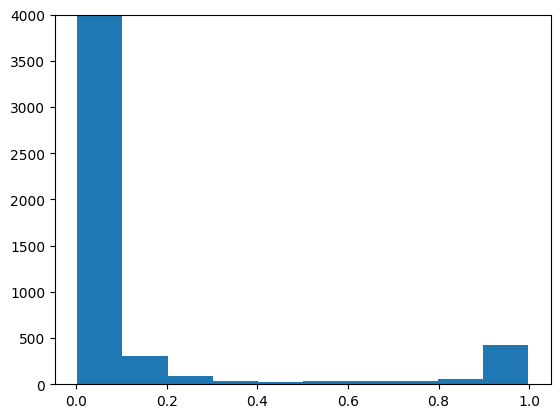

In [64]:
plt.hist(pred_logits, bins=10)
plt.ylim(0,4000)
plt.show()

In [65]:
dataset = dataset.add_column("pred_logits_bert", pred_logits)


# Push dataset to huggingface hub

In [66]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
Your token has been saved to /root/.c

In [67]:
dataset.push_to_hub("fhens/dutch_tweets_roman_empire", private=True)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/163 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/1.28k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/fhens/dutch_tweets_roman_empire/commit/a7397cebf73733c5f1d4ed363daa29103a600411', commit_message='Upload dataset', commit_description='', oid='a7397cebf73733c5f1d4ed363daa29103a600411', pr_url=None, pr_revision=None, pr_num=None)

In [68]:
from datasets import load_dataset

dataset = load_dataset("fhens/dutch_tweets_roman_empire", split="train")
dataset

Generating train split:   0%|          | 0/162805 [00:00<?, ? examples/s]

Dataset({
    features: ['full_text', 'text_translation', 'screen_name', 'description', 'desc_translation', 'location', 'weekofyear', 'weekday', 'month', 'year', 'day', 'point_info', 'point', 'latitude', 'longitude', 'altitude', 'province', 'hisco_standard', 'hisco_code', 'industry', 'sentiment_pattern', 'subjective_pattern', 'label', 'pred_logits_bert'],
    num_rows: 162805
})

# Save as csv

In [69]:
dataset.to_csv("tweets_2020_predicted.csv")

Creating CSV from Arrow format:   0%|          | 0/163 [00:00<?, ?ba/s]

97387658

# LOAD FROM HERE IF ONLY INFERENCE
You can contact me via email for the required files.

# Load classified data csv

In [70]:
import transformers
import datasets
import pandas as pd
import regex as re
import numpy as np
from sklearn.model_selection import train_test_split
import torch

tweets_2020 = pd.read_csv("drive/MyDrive/tweets_2020_predicted.csv")
tweets_2020.columns

Index(['full_text', 'text_translation', 'screen_name', 'description',
       'desc_translation', 'location', 'weekofyear', 'weekday', 'month',
       'year', 'day', 'point_info', 'point', 'latitude', 'longitude',
       'altitude', 'province', 'hisco_standard', 'hisco_code', 'industry',
       'sentiment_pattern', 'subjective_pattern', 'label', 'pred_logits_bert'],
      dtype='object')

In [71]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

roman_empire_tweets = tweets_2020[tweets_2020["pred_logits_bert"] > 0.5]
roman_empire_tweets

,full_text,text_translation,screen_name,description,desc_translation,location,weekofyear,weekday,month,year,...,longitude,altitude,province,hisco_standard,hisco_code,industry,sentiment_pattern,subjective_pattern,label,pred_logits_bert
34,RT @GrandpaSnarky: Chuck Todd Grills RNC Chair...,RT @GrandpaSnarky Chuck Todd Grills RNC Chairw...,OpenMarketingTV,"YouTube, Amazon Video Direct Partner, Internet...","YouTube, Amazon Instant Video Partner, Interne...",Amsterdam,38,1,9,2020,...,4.893604,0.0,Noord-Holland,resident,20210,True,0.000000,0.000000,1,0.609933
824,RT @hemicker: Von wegen #GermanAngst. Die groß...,RT @hemicker: Von roads #GermanAngst. Die groß...,julalouise,GP and Managing Partner of Huisartsenpraktijk ...,GP and Managing Partner of General Practice Cl...,Netherlands,10,4,3,2020,...,5.748082,0.0,Flevoland,None,None,False,0.000000,0.000000,1,0.632257
1304,RT @HubertDeMeulder: Coronavirus dijt uit: noo...,RT @HubertDeMeulder: Coronavirus is expanding:...,josdevlaming,Geen respect meer voor (anti)politiek.\nIk wil...,No respect for (anti) politics.\nI want the Eu...,Flanders,5,4,1,2020,...,4.178629,0.0,False,None,None,False,0.000000,0.100000,1,0.996650
1543,RT @PhoenixNLer: 17 augustus openen de scholen...,RT @PhoenixNLer: August 17 open schools in nor...,roelgrif,"Mathematician, IT guy, musician and justice su...","Mathematician, IT guy, musician and justice su...",The Netherlands,32,3,8,2020,...,5.748082,0.0,Flevoland,None,None,False,0.300000,0.466667,2,0.996453
1755,op1 Twee Surinaamse vrouwen laten de wereld zi...,op1 Two Surinamese women show the world how yo...,william_HHW,None,None,None,18,0,4,2020,...,0.000000,0.0,False,None,None,False,0.404167,0.770833,2,0.722017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161552,RT @BryanRoyAjax: Hoezo staat Thierry niet zo ...,RT @BryanRoyAjax: Why Thierry is not as if thi...,RedDrag32738516,Het Grote Ontwaken is gaande. Kom maar hier vo...,The Great Awakening is underway. Come here for...,None,21,0,5,2020,...,0.000000,0.0,False,None,None,False,0.000000,0.000000,1,0.593476
161947,RT @JoopSoesan: Het zijn en blijven net kinder...,RT @JoopSoesan: They are and remain just child...,w12move,None,None,None,30,3,7,2020,...,0.000000,0.0,False,leider,22000,True,0.550000,0.850000,2,0.866576
162489,RT @IndoPac_Info: #Malaysia detects new #coron...,RT @IndoPac_Info: #Malaysia Detects #coronavir...,Ko_Nijn68,"Ev'rybody's talking about\nBagism, Shagism, Dr...","Ev'rybody's talking about\nBagism, Shagism, Dr...",Netherlands,34,2,8,2020,...,5.748082,0.0,Flevoland,None,None,False,0.000000,0.000000,1,0.666488
162566,Is de Italiaanse maffia actief in België?. De ...,The Italian mafia active in Belgium ?. The Cam...,secunews_asbl,Secunews propose un flux d'informations quotid...,Secunews propose un flux d'informations à un q...,Belgique,35,1,8,2020,...,4.666715,0.0,False,"min, handlanger","7410, 99910",True,-0.041667,0.504167,1,0.577908


# Combine name, description and tweet

In [72]:
screennames = roman_empire_tweets.screen_name
descs_eng = roman_empire_tweets.desc_translation
tweets_eng = roman_empire_tweets.text_translation

def combine_info(screenname, desc, tweet):
    return f"Name: {screenname}, Description: {desc}, Text: {tweet}."

name_desc_tweet = [combine_info(name, desc, tweet) for name, desc, tweet in zip(list(screennames), list(descs_eng), list(tweets_eng))]
print(name_desc_tweet[0])

Name: OpenMarketingTV, Description: YouTube, Amazon Instant Video Partner, Internet / Social Media Marketing, SEO, Photography, Video, Herding Cats, #HeForShe, Text: RT @GrandpaSnarky Chuck Todd Grills RNC Chairwoman for Deflecting to Joe Biden Over 'Failed' U.S. Covid Response: "He's Not the President, ....


# Classify gender by finetuned Bert from Huggingface

In [73]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model = AutoModelForSequenceClassification.from_pretrained("padmajabfrl/Gender-Classification")
tokenzier = AutoTokenizer.from_pretrained("padmajabfrl/Gender-Classification")

model.to(device)
inputs = tokenzier(name_desc_tweet, padding=True, truncation=True, return_tensors="pt").to(device)

logits_ls = []
with torch.no_grad():
    logits = model(**inputs).logits
    logits_ls.extend(torch.nn.functional.softmax(logits, dim=-1)[:, 1].cpu().numpy())

### Ignore uncertain classifications

Since these are probably from organisations like the news, or weather update channels. Classifying these as male/female makes no sense.

In [74]:
certain_logits = [logit for logit in logits_ls if not (0.35 <= logit <= 0.65)]
uncertain_logits = [logit for logit in logits_ls if (0.35 <= logit <= 0.65)]

predicted_classes = np.array(certain_logits) > 0.5

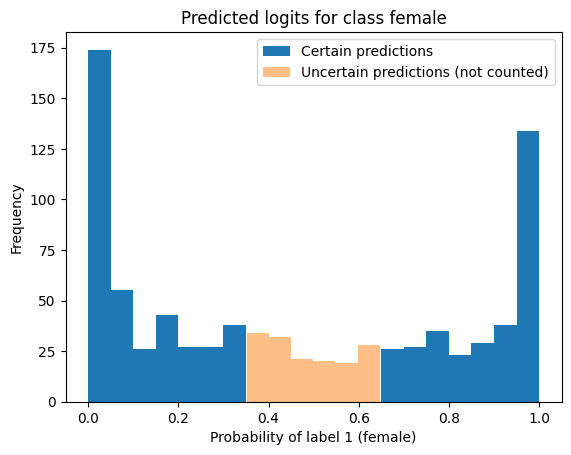

In [75]:
import matplotlib.pyplot as plt

plt.hist(certain_logits, bins=20, label="Certain predictions")
# bin width for certain: 1/20 = 0.05
# so bin width for uncertain should be 0.05 for 0.65-0.35 = 0.3 width
# so we need 0.3/0.05 = 6 bins!
plt.hist(uncertain_logits, bins=6, alpha=0.5, label="Uncertain predictions (not counted)")
plt.title("Predicted logits for class female")
plt.legend()
plt.xlabel("Probability of label 1 (female)")
plt.ylabel("Frequency")
plt.show()

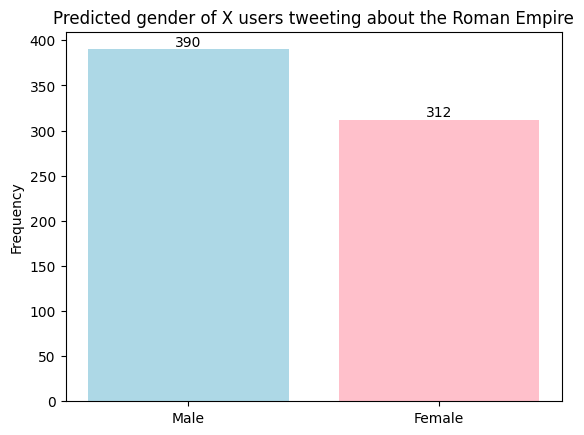

In [76]:
amt_male = len(predicted_classes[predicted_classes == 0])
amt_female = len(predicted_classes[predicted_classes == 1])

plt.bar(0, amt_male, color="lightblue")
plt.text(0, amt_male, str(amt_male), ha='center', va='bottom')
plt.bar(1, amt_female, color="pink")
plt.text(1, amt_female, str(amt_female), ha='center', va='bottom')
plt.xticks((0, 1), ("Male", "Female"))
plt.ylabel("Frequency")
plt.title("Predicted gender of X users tweeting about the Roman Empire")
plt.show()